In [1]:
import torch
from torchvision import datasets, transforms
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import cv2
import medmnist
from medmnist import INFO
import torch.optim as optim
from tqdm import tqdm

In [2]:

data_flag = 'breastmnist'
download = False

NUM_EPOCHS = 100
BATCH_SIZE = 64
lr = 0.01

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [3]:
from torch.utils.data import DataLoader

# Augmentation for the training dataset
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally
    transforms.RandomRotation(10),  # Rotate images by ±10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust brightness, contrast, etc.
    transforms.RandomResizedCrop(size=28, scale=(0.8, 1.0)),  # Random crop with scaling
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# No augmentation for validation & test sets (only normalization)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load datasets with appropriate transformations
train_dataset = DataClass(split='train', transform=train_transform, download=download)
validation_dataset = DataClass(split='val', transform=test_transform, download=download)
test_dataset = DataClass(split='test', transform=test_transform, download=download)

# Encapsulate datasets into DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=True)

# Print dataset sizes
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(validation_dataset)}")
print(f"Test samples: {len(test_dataset)}")


Training samples: 546
Validation samples: 78
Test samples: 156


In [4]:
print(train_dataset)
print("===================")
print(validation_dataset)
print("===================")
print(test_dataset)

Dataset BreastMNIST of size 28 (breastmnist)
    Number of datapoints: 546
    Root location: /home/oussama/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 'normal, benign'}
    Number of samples: {'train': 546, 'val': 78, 'test': 156}
    Description: The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.
    License: CC BY 4.0
Dataset BreastMNIST of size 28 (breastmnist)
    Number of datapoints: 78
    Root location: /home/oussama/.medmnist
    Split: val
    Task: binary-class
    Number of channels: 1
    Meani

In [5]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [6]:
class Square(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, t):
        return torch.pow(t, 2)

In [7]:
model = nn.Sequential(
    nn.Conv2d(1, 4, kernel_size=5),
    Square(),
    nn.AvgPool2d(kernel_size=2),

    nn.Conv2d(4, 12, kernel_size=5),
#     Square(),
    nn.AvgPool2d(kernel_size=2),

    nn.AdaptiveAvgPool2d((1, 1)),
    
    nn.Flatten(),
    
    nn.Linear(12, 10),
)


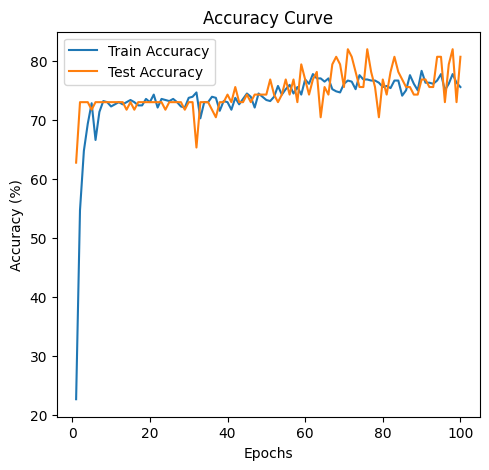

In [12]:
# Plot accuracy and loss curves
epochs = range(1, NUM_EPOCHS + 1)
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, validation_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.legend()

plt.show()

In [14]:
# Move the model to the selected device
model.to(device)
model.eval()  # Set the model to evaluation mode

# Loop through each image in the list and perform inference
for i, sample_image in enumerate(images_list):
    # Add a batch dimension (N, C, H, W) as the model expects batched inputs
    sample_image = sample_image.unsqueeze(0).to(device)

    # Forward pass
    with torch.no_grad():
        output = model(sample_image)


    # Calculate probabilities using softmax
    probabilities = torch.softmax(output, dim=1)

    # Get the predicted class
    predicted_class = torch.argmax(probabilities, dim=1)

    # Print the results
    print(f"Image {i} (Digit {i}):")
    print(f"Output Shape: {output.shape}")
    print(f"Probabilities: {probabilities}")
    print(f"Predicted Class: {predicted_class.item()}\n")

Image 0 (Digit 0):
Output Shape: torch.Size([1, 10])
Probabilities: tensor([[2.6673e-01, 7.3318e-01, 8.5938e-06, 1.6293e-05, 1.4835e-05, 8.4405e-06,
         9.7728e-06, 1.2833e-05, 6.2978e-06, 1.1750e-05]], device='cuda:0')
Predicted Class: 1

Image 1 (Digit 1):
Output Shape: torch.Size([1, 10])
Probabilities: tensor([[2.6124e-01, 7.3858e-01, 1.6961e-05, 3.0001e-05, 2.8470e-05, 1.7577e-05,
         1.9943e-05, 2.4151e-05, 1.3096e-05, 2.4778e-05]], device='cuda:0')
Predicted Class: 1



In [15]:
# Directory to save CAM images
output_dir = "Mnist_cam/Breast/plain/"
import os
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist

In [16]:
from PIL import Image
from torchvision.transforms.functional import to_pil_image

In [17]:
def get_feature_maps(module, input, output):
    global feature_maps
    feature_maps = output

In [18]:
def compute_cam(sample_image):
    # Define a hook to get the feature maps
    # feature_maps = None
    
    # Register the hook on the last convolutional layer
    hook = model[3].register_forward_hook(get_feature_maps)
    
    # Forward pass to get predictions and feature maps
    with torch.no_grad():
        output = model(sample_image)
    

    # Remove the hook
    hook.remove()

    # Get the predicted class
    _, predicted_class = torch.max(output, 1)

    # Get the weights of the output layer for the predicted class
    weights = model[-1].weight.data  # Last Linear layer
    class_weights = weights[predicted_class.item()]

    # Compute the Class Activation Map (CAM)
    cam = torch.matmul(class_weights.unsqueeze(0), feature_maps.view(feature_maps.size(1), -1)).reshape(feature_maps.size(2), feature_maps.size(3)).cpu().numpy()

    cam = np.maximum(cam, 0)  # Apply ReLU

    # Normalize the CAM
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)
    
    # Resize CAM to match the input image dimensions
    cam = cv2.resize(cam, (28, 28))  # Resize to MNIST image size
    return cam

In [19]:
def display_cam(cam, i):

    # Visualize the CAM
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(sample_image.squeeze().cpu().numpy(), cmap='gray')
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(cam, cmap='jet', alpha=0.5)  # Overlay the CAM on the image
    plt.title('Class Activation Map (CAM)')
    plt.colorbar()

    # Save the visualization before showing it
    output_path = os.path.join(output_dir, f"digit_{i}_cam.png")
    plt.savefig(output_path)  # Save the current figure

    # Now show the image
    plt.show()

    # Close the figure to prevent memory issues
    plt.close()


In [20]:
def display_superposed_image(sample_image, cam, i):
    # Convertir l'image d'origine en PIL
    original_img = to_pil_image(sample_image.squeeze().cpu(), mode='L')  # mode='L' pour niveaux de gris

    # Normaliser le CAM
    cam = (cam - cam.min()) / (cam.max() - cam.min())  # Normalisation
    cam_colored = cv2.applyColorMap((cam * 255).astype(np.uint8), cv2.COLORMAP_JET)  # Utiliser 'jet' pour colorer le mask
    cam_colored = cv2.cvtColor(cam_colored, cv2.COLOR_BGR2RGB)  # Convertir en RGB pour PIL
    cam_img = Image.fromarray(cam_colored)  # Convertir en image PIL

    # Redimensionner la CAM colorée pour correspondre à l'image d'origine
    cam_img = cam_img.resize(original_img.size, Image.BILINEAR)

    # Superposer la CAM colorée avec l'image en niveaux de gris
    def overlay_mask(original, mask, alpha=0.5):
        return Image.blend(original.convert("RGB"), mask, alpha)

    # Afficher la superposition
    result = overlay_mask(original_img, cam_img, alpha=0.7)  # Ajustez alpha si nécessaire
    plt.imshow(result)
    plt.axis('off')
    
    # Save the visualization before showing it
    output_path = os.path.join(output_dir, f"digit_{i}_superposed_cam_.png")
    plt.savefig(output_path)  # Save the current figure
    
    plt.show()
    
    plt.close()

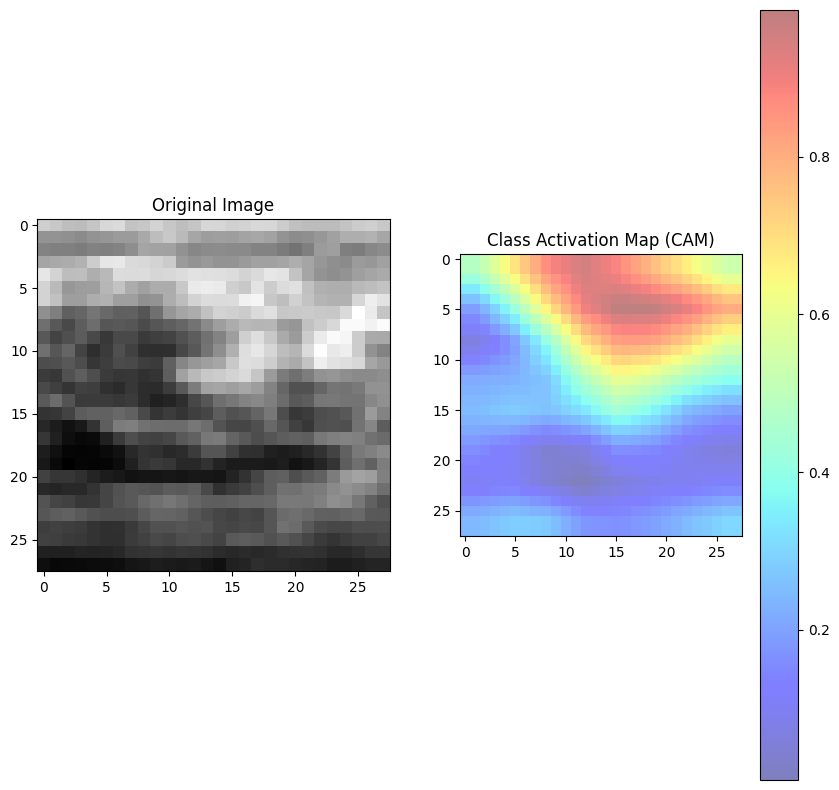

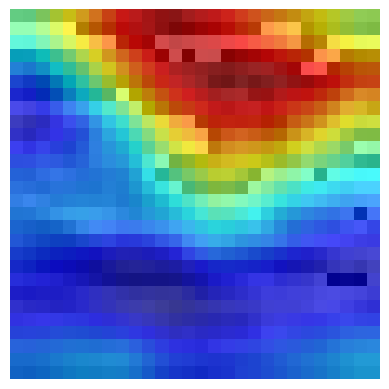

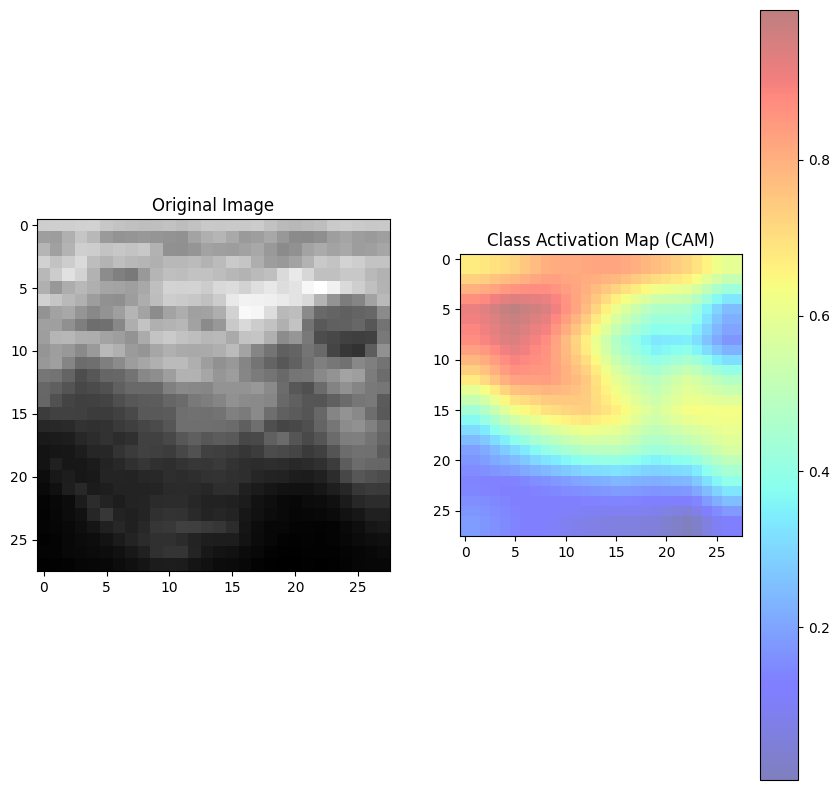

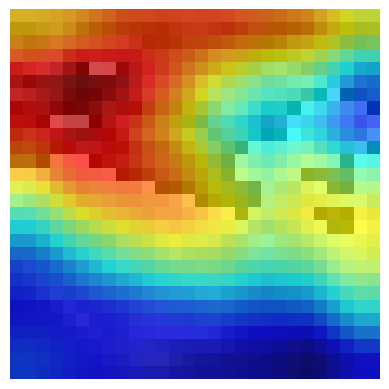

In [22]:
for i, sample_image in enumerate(images_list):
    
    # Add a batch dimension (N, C, H, W) as the model expects batched inputs
    sample_image = sample_image.unsqueeze(0).to(device)
    cam = compute_cam(sample_image)
    display_cam(cam, i)
    display_superposed_image(sample_image, cam, i)

In [23]:
import sys
import os

# Add the directory containing 'pycrcnn' to sys.path
sys.path.append(os.path.abspath(".."))  # Adjust the path as needed

In [24]:
from pycrcnn.he.HE import CKKSPyfhel
from pycrcnn.model.sequential import Sequential
import time

In [25]:
start_time = time.time()

n_mults = 7
m = 8192
scale_power = 22

encryption_parameters = {
    'm': m,                      # For CKKS, n/2 values can be encoded in a single ciphertext
    'scale': 2**scale_power,                 # Each multiplication grows the final scale
    'qi': [30]+ [scale_power]*n_mults +[30]  # One intermdiate for each multiplication
}


HE_Client = CKKSPyfhel(**encryption_parameters)
HE_Client.generate_keys()
HE_Client.generate_relin_keys()

public_key = HE_Client.get_public_key()
relin_key  = HE_Client.get_relin_key()


HE_Server = CKKSPyfhel(**encryption_parameters)
HE_Server.load_public_key(public_key)
HE_Server.load_relin_key(relin_key)

requested_time = round(time.time() - start_time, 2)
print(f"\nThe context generation requested {requested_time} seconds.")


The context generation requested 1.51 seconds.


In [26]:
model.to('cpu')

Sequential(
  (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
  (1): Square()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(4, 12, kernel_size=(5, 5), stride=(1, 1))
  (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (5): AdaptiveAvgPool2d(output_size=(1, 1))
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=12, out_features=10, bias=True)
)

In [27]:
model_encoded = Sequential(HE_Server, model)

Encoding convolutional layer took 0.20 seconds
Encoding Conv2d took 0.20 seconds
Encoding Square took 0.00 seconds
Encoding AvgPool2d took 0.00 seconds
Encoding convolutional layer took 2.18 seconds
Encoding Conv2d took 2.18 seconds
Encoding AvgPool2d took 0.00 seconds
Encoding AdaptiveAvgPool2d took 0.00 seconds
Encoding Flatten took 0.00 seconds
Encoding Linear took 0.23 seconds


In [28]:
def image_encryption(sample_image):
    encrypted_image = HE_Client.encrypt_matrix(sample_image.unsqueeze(0).numpy())
    return encrypted_image

In [29]:
def compute_encrypted_cam(encrypted_feature_maps, weights, HE):
    # Assuming feature_maps shape is [12, height, width], weights shape is [12]
    channels = len(encrypted_feature_maps[0])
    width = len(encrypted_feature_maps[0][0])
    height = len(encrypted_feature_maps[0][0][0])

    print(height, width, channels)  
    # Initialize the encrypted CAM with the appropriate shape [height, width]
    encrypted_cam = [[None for _ in range(width)] for _ in range(height)]

    # Iterate through each pixel in the feature map
    for i in range(height):
        for j in range(width):
            # Initialize the encrypted CAM value at (i, j) with zero (encrypted)
            cam_value = HE.encrypt(0)  # Start with encrypted zero

            # Perform the weighted sum across all channels
            for k in range(channels):
                # Extract the pixel value from the feature map at (i, j) for channel k
                feature_pixel = encrypted_feature_maps[0][k][i][j]

                # Multiply the pixel value by the corresponding weight
                weighted_value = feature_pixel * weights[k]

                # Add the weighted value to the CAM (rescale if necessary)
                HE.he.rescale_to_next(weighted_value)  # Optional, depending on your encryption scheme
                cam_value += weighted_value

            # Store the resulting encrypted CAM value
            encrypted_cam[i][j] = cam_value
    
    cam = HE.decrypt_matrix(encrypted_cam)
    
    print(cam)
    cam = np.maximum(cam, 0)  # Apply ReLU

    # Normalize the CAM
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)

    # Resize CAM to match the input image dimensions
    cam = cv2.resize(cam, (28, 28))  # Resize to MNIST image size
    
    # cam = np.array(cam, dtype=np.float32)
    
    return cam

In [30]:
# Directory to save CAM images
output_dir = "Mnist_cam/Breast/cam_encrypted_images/"
import os
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist

the convolutional layer took 70.67 seconds
The Square layer took 34.35 seconds
the average pooling layer tooks 1.21 seconds
the convolutional layer took 208.47 seconds
the average pooling layer tooks 0.34 seconds
the adaptive average pooling layer took 0.10 seconds
the linear layer tooks 0.23 seconds
8 8 12
[[13.18432781 16.36911696 19.56044529 20.82825663 19.59186271 17.81129086
  16.03412658 14.14990575]
 [ 8.73421683 12.24169554 16.65362793 20.06503267 21.56209746 21.4314043
  20.4006162  18.61008091]
 [ 6.46781193  8.24768421 11.95879188 16.61704578 18.85861841 18.66953681
  16.9970031  14.80303157]
 [ 8.93566814  9.118821    9.85684898 13.11947994 15.44713904 14.4926081
  12.91993871 11.76502271]
 [ 9.54814382 10.09534769  9.62801273 10.5803861  12.41696537 11.11480802
   9.22183762  8.46486738]
 [ 8.17598736  7.32768902  6.19508815  6.6993712   8.37167001  8.01655898
   6.93480127  6.40087975]
 [ 7.1159825   7.36285541  6.35289558  5.53962247  6.41026012  6.86525696
   7.06544271

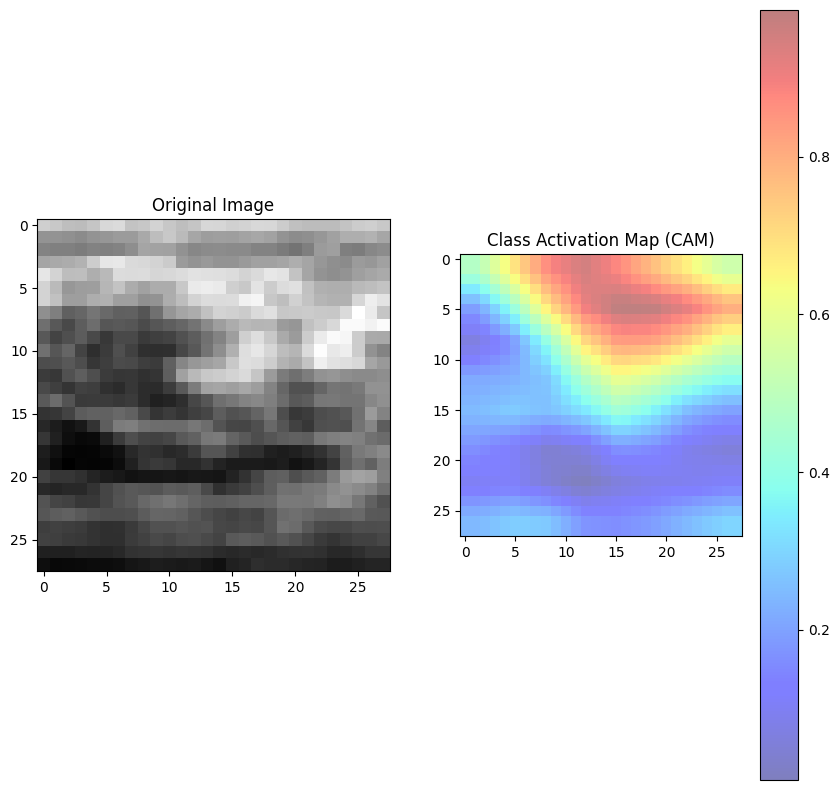

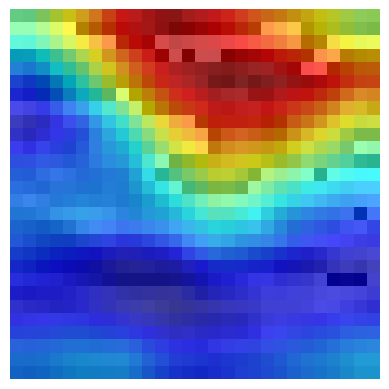

the convolutional layer took 69.14 seconds
The Square layer took 32.98 seconds
the average pooling layer tooks 0.89 seconds
the convolutional layer took 209.10 seconds
the average pooling layer tooks 0.31 seconds
the adaptive average pooling layer took 0.12 seconds
the linear layer tooks 0.19 seconds
8 8 12
[[12.79598152 13.28864205 14.25154773 14.39177507 14.49852829 13.91514734
  13.31202972 11.97098085]
 [15.55875099 16.44513884 15.82384683 14.1808082  12.06071596 10.66142426
  10.51612453  8.20074267]
 [14.98498962 15.85652102 14.87829993 12.82367791 10.23110579  8.82123726
   9.1253403   7.13802117]
 [13.07171178 14.72446723 14.73626022 13.79401599 11.75210768 10.60096313
  11.66061211 10.46001014]
 [ 9.95462814 11.98326357 12.99466707 13.53771528 12.7436963  11.49853093
  12.39792391 12.4017126 ]
 [ 7.49184079  8.82169427 10.04984864 10.93741755 11.03529895 10.15926063
  10.62636732 11.64134159]
 [ 6.74969152  6.61636454  6.95370401  7.40090407  7.7306399   7.52411802
   7.784253

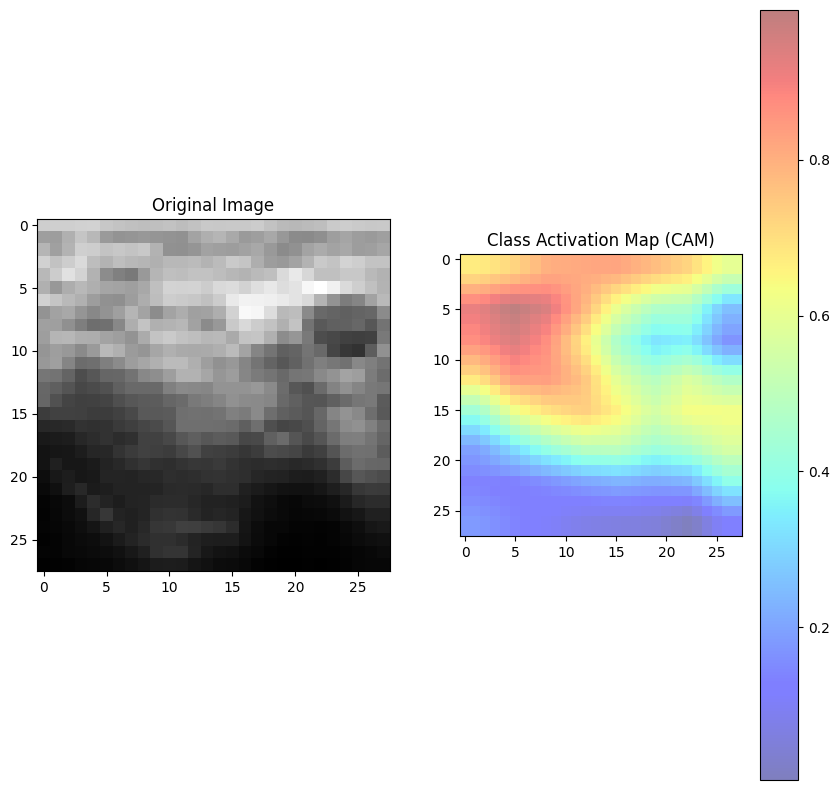

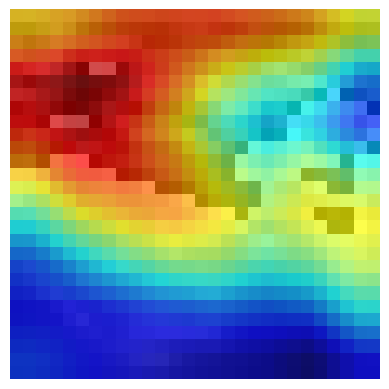

In [31]:
for i, sample_image in enumerate(images_list):
    # Iterate through a list of images. 'i' is the index, 'sample_image' is the image.

    # Add a batch dimension (N, C, H, W) as the model expects batched inputs.
    # unsqueeze(0) adds a dimension at the 0th position (making it a batch of 1).
    # .to("cpu") moves the tensor to the CPU.  Important for compatibility with some encryption libraries.
    sample_image = sample_image.unsqueeze(0).to("cpu")

    for x in range(1):
        # Loop twice for each image (likely for some kind of repeated processing or variation).

        # Encrypt the image using the 'image_encryption' function.
        encrypted_image = image_encryption(sample_image)

        # Pass the encrypted image through the encoded model ('model_encoded').
        # .squeeze(2) removes a dimension of size 1 (likely added by the encryption).
        # debug=False likely disables debugging output within the model.
        encrypted_output = model_encoded(encrypted_image.squeeze(2), debug=False)

        # Decrypt the output using the HE_Client's decryption method.
        result = HE_Client.decrypt_matrix(encrypted_output)

        # Get the weights of the linear layer of the encoded model.
        linear_layer = model_encoded.get_linear_layer()
        weights = linear_layer.get_weights()  # Get the Linear layer weights

        # Select the weights corresponding to the predicted class (the one with the highest score in 'result').
        class_weights = weights[np.argmax(np.array(result)[0])]

        # Get the feature maps from the encoded model.  These are the activations of the convolutional layers.
        feature_maps = model_encoded.get_feature_map()

        # Compute the Class Activation Map (CAM) using the encrypted output and the model.
        # CAM highlights the regions of the image that are most influential for the model's prediction.
        cam = compute_encrypted_cam(feature_maps, class_weights, HE_Client)

        print(f"Type of cam: {type(cam)}")
        # Display the CAM. 'i' is the image index, 'x' is the inner loop index.
        display_cam(cam, i)

        # Superpose the CAM onto the original image and display the result.
        display_superposed_image(sample_image, cam, i)